In [151]:
import pandas as pd
import json
from typing import Dict, List
import re
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import single_meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from difflib import SequenceMatcher
import spacy
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict, List
import evaluate



In [ ]:
# %pip install spacy rouge-score nltk
# !python -m spacy download en_core_web_md
# %pip install evaluate

In [161]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_md')
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge = evaluate.load("rouge")


[nltk_data] Downloading package punkt to /home/asuran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/asuran/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/asuran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [153]:
def create_evaluation_dataframe(records):
    """Create comprehensive dataframe with all relevant fields"""
    evaluation_data = []
    
    for record in records:
        try:
            patient_info = {
                # Patient Demographics
                'patient_id': record['patientId'],
                'gender': record['patientRecord']['Gender'],
                'age': int(record['patientRecord']['Age']),
                'weight': float(record['patientRecord']['Weight']),
                'height': float(record['patientRecord']['Height']),
                'blood_type': record['patientRecord']['Blood type'],
                'severity': record['patientRecord']['Severity'],
                'symptom_duration': record['patientRecord']['Duration of the symptoms'],
                'num_previous_visits': record['patientRecord']['Number of previous visits'],
                'symptoms': record['patientRecord']['Detailed symptoms'],
                'existing_conditions': record['patientRecord']['Existing medical conditions'],
                'allergies': record['patientRecord']['Allergies'],
                'medications': record['patientRecord']['Current medications'],
                
                # Ground Truth (Palm2 Model)
                'gt_primary_diagnosis': record['diagnosisReport']['Possible Diagnoses']['Primary Diagnosis'],
                'gt_differential_diagnoses': ','.join(record['diagnosisReport']['Possible Diagnoses']['Differential Diagnoses']),
                'gt_reasoning': record['diagnosisReport']['Reasoning Process'],
                'gt_tests': record['diagnosisReport']['Recommended Tests or Examinations'],
                'gt_treatments': record['diagnosisReport']['Potential Treatment Options'],
                'gt_precautions': record['diagnosisReport']['Immediate Precautions or Recommendations'],
                'gt_followup': record['diagnosisReport']['Follow-up Plan'],
                
                # Model Predictions (Med42)
                'pred_primary_diagnosis': record['med42_diagnosis']['Possible Diagnoses']['Primary Diagnosis'],
                'pred_differential_diagnoses': ','.join(record['med42_diagnosis']['Possible Diagnoses']['Differential Diagnoses']),
                'pred_reasoning': record['med42_diagnosis']['Reasoning Process'],
                'pred_tests': record['med42_diagnosis']['Recommended Tests or Examinations'],
                'pred_treatments': record['med42_diagnosis']['Potential Treatment Options'],
                'pred_precautions': record['med42_diagnosis']['Immediate Precautions or Recommendations'],
                'pred_followup': record['med42_diagnosis']['Follow-up Plan']
            }
            
            evaluation_data.append(patient_info)
            
        except Exception as e:
            print(f"Error processing record {record['patientId']}: {str(e)}")
            continue
    
    return pd.DataFrame(evaluation_data)

In [154]:
# Load the JSON data
with open('records_with_med42.json', 'r') as f:
    records = json.load(f)

In [155]:
# Create the dataframe
df = create_evaluation_dataframe(records)

In [156]:
print("DataFrame shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of the data:")
display(df.head())

DataFrame shape: (708, 27)

Columns: ['patient_id', 'gender', 'age', 'weight', 'height', 'blood_type', 'severity', 'symptom_duration', 'num_previous_visits', 'symptoms', 'existing_conditions', 'allergies', 'medications', 'gt_primary_diagnosis', 'gt_differential_diagnoses', 'gt_reasoning', 'gt_tests', 'gt_treatments', 'gt_precautions', 'gt_followup', 'pred_primary_diagnosis', 'pred_differential_diagnoses', 'pred_reasoning', 'pred_tests', 'pred_treatments', 'pred_precautions', 'pred_followup']

Sample of the data:


,patient_id,gender,age,weight,height,blood_type,severity,symptom_duration,num_previous_visits,symptoms,...,gt_treatments,gt_precautions,gt_followup,pred_primary_diagnosis,pred_differential_diagnoses,pred_reasoning,pred_tests,pred_treatments,pred_precautions,pred_followup
0,2,Female,72,68.0,157.0,O-,Severe,3 weeks,5,Severe lower back pain radiating down the righ...,...,- Conservative management: For mild to modera...,"- Avoid activities that exacerbate the pain, i...",- Follow-up appointment in one week to discuss...,,,,,,,
1,3,Female,67,72.0,163.0,O+,Moderate to Severe (increasing in severity),3 months,"2 (one for knee pain, one for routine bloodwork)",Persistent epigastric pain radiating to the ba...,...,- Proton Pump Inhibitors (PPIs): To reduce gas...,- Urgent medical attention is needed for persi...,- Follow up appointment scheduled immediately ...,Gastroesophageal Reflux Disease (GERD),"Peptic ulcer disease,Gastric cancer,Gastrointe...",The patient's persistent epigastric pain radia...,- Upper GI endoscopy\n- Radiographic imaging o...,- Lifestyle modifications (dietary adjustments...,"- Avoid foods that trigger symptoms (e.g., spi...",- Continue monitoring weight loss and adjust d...
2,1,Female,72,63.0,155.0,A-,Severe,6 weeks,4,Severe lower back pain radiating down the righ...,...,"- Conservative Management: Initially, treatme...",- Avoid activities that exacerbate pain.\n- Ma...,- Follow up appointment in 2 weeks to assess r...,,,- The patient's age and chronic conditions (os...,- MRI of the lumbar spine with contrast\n- Ele...,- Conservative management:\n - Physical thera...,- Discontinue Acetaminophen due to potential h...,- Schedule follow-up appointments every 2 week...
3,4,Female,68,72.0,160.0,A-,Severe,12 hours,5,"Intense, sharp right-sided flank pain radiatin...",...,- Analgesia: Intravenous morphine or other st...,- Immediate pain management is paramount given...,- Close monitoring of the patient’s pain level...,Acute Renal Colic,"Pyelonephritis,Kidney Stones",The primary diagnosis of Acute Renal Colic is ...,- Urinalysis (UA) with microscopy to assess fo...,"- Immediate alpha-blocker (e.g., Tamsulosin) t...",- Monitor vital signs closely including blood ...,- Schedule follow-up appointment within 2 week...
4,5,Female,72,68.0,160.0,A+,Severe,3 days,12,"Severe, persistent right-sided flank pain radi...",...,- For renal colic: Analgesics (such as NSAIDs...,- Pain management: Provide strong analgesics (...,- Close follow-up within 48 hours after receiv...,Renal calculi/nephrolithiasis,"Pyelonephritis,Renovascular hypertension","The primary diagnosis, renal calculi (nephroli...",- Abdominal CT scan with intravenous contrast ...,- Definitive treatment once imaging confirms r...,- Provide adequate pain management to ensure p...,- Obtain imaging results and review with the p...


In [157]:
def add_derived_features(df):
    """Add derived features and metrics to the dataframe"""
    
    # Store original columns
    original_columns = df.columns.tolist()
    
    # Calculate BMI
    df['bmi'] = df['weight'] / ((df['height']/100) ** 2)
    
    # Convert symptom duration to days
    def duration_to_days(duration):
        try:
            duration = str(duration).lower()
            if 'week' in duration:
                return int(duration.split()[0]) * 7
            elif 'month' in duration:
                return int(duration.split()[0]) * 30
            elif 'day' in duration:
                return int(duration.split()[0])
            return 0
        except:
            return 0
    
    df['symptom_duration_days'] = df['symptom_duration'].apply(duration_to_days)
    

    df['num_conditions'] = df['existing_conditions'].str.count(',') + 1
    

    df['num_medications'] = df['medications'].str.count(',') + 1
    

    new_columns = [col for col in df.columns if col not in original_columns]
    print("Added derived features. New columns:", new_columns)
    
    return df



In [158]:
# Add derived features
df = add_derived_features(df)

Added derived features. New columns: ['bmi', 'symptom_duration_days', 'num_conditions', 'num_medications']


In [159]:
def calculate_bleu(references, candidates, weights):
    """Calculate BLEU score"""
    tokenized_candidates = [text.split() for text in candidates]
    tokenized_references = [[text.split()] for text in references]
    bleu_scores = corpus_bleu(tokenized_references, tokenized_candidates, weights=weights)
    return bleu_scores

def calculate_rouge(references, candidates):
    """Calculate ROUGE scores"""
    return rouge.compute(predictions=candidates, references=references)

def calculate_meteor(references, candidates):
    """Calculate METEOR score"""
    scores = [single_meteor_score(ref.split(), hyp.split()) 
             for ref, hyp in zip(references, candidates)]
    return sum(scores)/len(scores)

def jaccard_similarity(reference, generated):
    """Calculate Jaccard similarity"""
    generated_tokens = set(generated.split())
    reference_tokens = set(reference.split())
    intersection = len(generated_tokens & reference_tokens)
    union = len(generated_tokens | reference_tokens)
    return intersection / union if union > 0 else 0

def calculate_jaccard_similarity(references, candidates):
    """Calculate average Jaccard similarity"""
    scores = [jaccard_similarity(references[i], candidates[i]) 
             for i in range(len(references))]
    return sum(scores)/len(scores)

def evaluate_metrics(references, candidates, bleu_weights=(0.2, 0.3, 0.5)):
    """Calculate all evaluation metrics"""
    results = {
        'bleu': calculate_bleu(references, candidates, bleu_weights),
        'meteor_score': calculate_meteor(references, candidates),
        'jaccard_similarity': calculate_jaccard_similarity(references, candidates)
    }
    results.update(calculate_rouge(references, candidates))
    return results

def calculate_similarity_metrics(row):
    """Calculate comprehensive similarity metrics for a row"""
    metrics = {}
    
    # Primary Diagnosis Similarity
    primary_gt = str(row['gt_primary_diagnosis'])
    primary_pred = str(row['pred_primary_diagnosis'])
    
    # BLEU score
    metrics['primary_bleu'] = sentence_bleu(
        [word_tokenize(primary_gt.lower())],
        word_tokenize(primary_pred.lower())
    )
    
    # ROUGE scores
    rouge_scores = rouge_scorer.score(primary_gt, primary_pred)
    metrics['primary_rouge1'] = rouge_scores['rouge1'].fmeasure
    metrics['primary_rouge2'] = rouge_scores['rouge2'].fmeasure
    metrics['primary_rougeL'] = rouge_scores['rougeL'].fmeasure
    
    # Semantic similarity
    metrics['primary_semantic'] = nlp(primary_gt).similarity(nlp(primary_pred))
    
    # Sequence similarity
    metrics['primary_sequence'] = SequenceMatcher(None, primary_gt, primary_pred).ratio()
    
    # Differential Diagnoses Similarity
    diff_gt = row['gt_differential_diagnoses']
    diff_pred = row['pred_differential_diagnoses']
    diff_scores = rouge_scorer.score(diff_gt, diff_pred)
    metrics['diff_rouge1'] = diff_scores['rouge1'].fmeasure
    metrics['diff_rouge2'] = diff_scores['rouge2'].fmeasure
    metrics['diff_rougeL'] = diff_scores['rougeL'].fmeasure
    
    return pd.Series(metrics)

def calculate_evaluation_metrics(df):
    """Calculate all evaluation metrics before bias analysis"""
    print("Calculating evaluation metrics...")
    
    # Prepare references and candidates
    references = df['gt_primary_diagnosis'].tolist()
    candidates = df['pred_primary_diagnosis'].tolist()
    
    # Calculate all metrics
    results = evaluate_metrics(references, candidates, bleu_weights=(0.2, 0.3, 0.5))
    print("\nOverall Metrics:")
    print(json.dumps(results, indent=2))
    
    # Calculate detailed metrics for each row
    detailed_metrics = df.apply(calculate_similarity_metrics, axis=1)
    df_with_metrics = pd.concat([df, detailed_metrics], axis=1)
    
    print("\nSimilarity metrics summary:")
    metric_cols = [col for col in df_with_metrics.columns 
                  if any(x in col for x in ['bleu', 'rouge', 'semantic', 'sequence'])]
    display(df_with_metrics[metric_cols].describe())
    
    # Visualize metrics distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_with_metrics[[
        'primary_semantic', 'primary_sequence', 'primary_rouge1',
        'diff_rouge1', 'diff_rouge2', 'diff_rougeL'
    ]])
    plt.xticks(rotation=45)
    plt.title('Distribution of Similarity Metrics')
    plt.show()
    
    # Add agreement levels
    def classify_agreement(row):
        if row['primary_semantic'] > 0.8:
            return 'High'
        elif row['primary_semantic'] > 0.5:
            return 'Moderate'
        else:
            return 'Low'
    
    df_with_metrics['agreement_level'] = df_with_metrics.apply(classify_agreement, axis=1)
    agreement_dist = df_with_metrics['agreement_level'].value_counts()
    
    print("\nAgreement Level Distribution:")
    for level, count in agreement_dist.items():
        print(f"{level} Agreement: {count} cases ({count/len(df_with_metrics)*100:.1f}%)")
    
    return df_with_metrics

Calculating evaluation metrics...

Overall Metrics:
{
  "bleu": 0.022352282010556765,
  "meteor_score": 0.1378092300539018,
  "jaccard_similarity": 0.09395202264637545,
  "rouge1": 0.2406161703883954,
  "rouge2": 0.11448136978588913,
  "rougeL": 0.2364720578108614,
  "rougeLsum": 0.2368393878112574
}


/tmp/ipykernel_230270/929054057.py:63: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  metrics['primary_semantic'] = nlp(primary_gt).similarity(nlp(primary_pred))
/home/asuran/Downloads/projects/MedScript/MedEnv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/asuran/Downloads/projects/MedScript/MedEnv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/asuran/Downloads/projects/MedScript/MedEnv/lib/python3.12/sit


Similarity metrics summary:


,primary_bleu,primary_rouge1,primary_rouge2,primary_rougeL,primary_semantic,primary_sequence,diff_rouge1,diff_rouge2,diff_rougeL
count,7.080000e+02,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000
mean,2.332197e-02,0.248887,0.121688,0.244444,0.527165,0.350887,0.187470,0.070371,0.163902
std,1.159556e-01,0.239322,0.203726,0.236635,0.347932,0.220414,0.170426,0.113925,0.149414
min,0.000000e+00,0.000000,0.000000,0.000000,-0.001694,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.201899,0.000000,0.000000,0.000000
50%,6.016112e-232,0.200000,0.000000,0.200000,0.673421,0.363636,0.166667,0.000000,0.133333
75%,5.087741e-155,0.400000,0.222222,0.400000,0.796846,0.519481,0.300000,0.125000,0.260870
max,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,0.888889,0.625000,0.700000


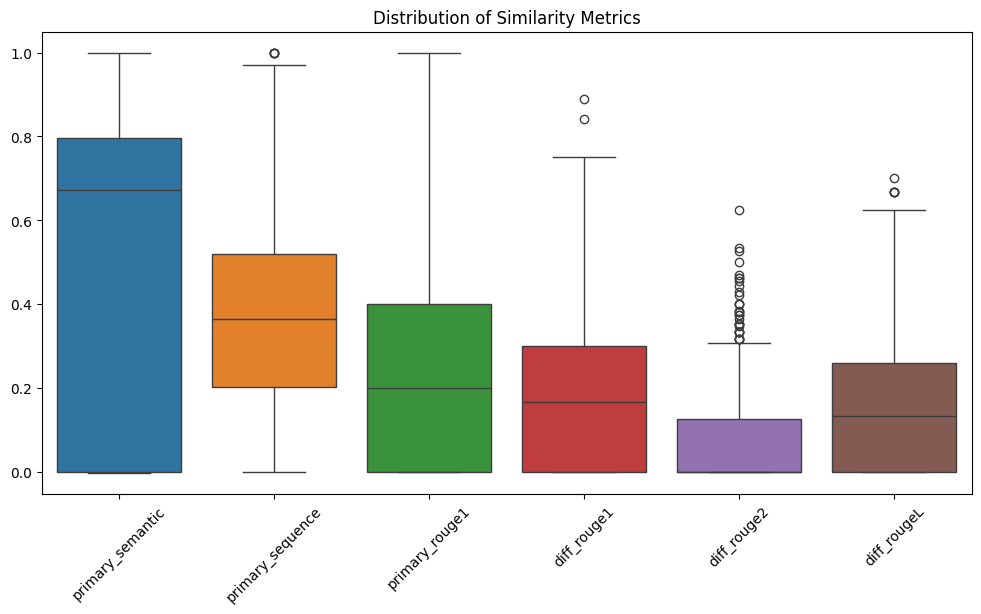


Agreement Level Distribution:
Moderate Agreement: 298 cases (42.1%)
Low Agreement: 237 cases (33.5%)
High Agreement: 173 cases (24.4%)


In [163]:
df_metrics = calculate_evaluation_metrics(df)

## Bias Analysis 

In [164]:
class MedicalBiasAnalyzer:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare data for bias analysis"""
        # Age groups
        self.df['age_group'] = pd.cut(
            self.df['age'], 
            bins=[0, 20, 40, 60, 80, 100],
            labels=['0-20', '21-40', '41-60', '61-80', '80+']
        )
        
        # Condition complexity
        self.df['condition_complexity'] = self.df['existing_conditions'].str.count(',').apply(
            lambda x: 'Simple' if x <= 2 else 'Moderate' if x <= 5 else 'Complex'
        )
        
        # BMI categories
        self.df['bmi_category'] = pd.cut(
            self.df['bmi'],
            bins=[0, 18.5, 24.9, 29.9, float('inf')],
            labels=['Underweight', 'Normal', 'Overweight', 'Obese']
        )
        
        # Symptom severity standardization
        self.df['severity'] = self.df['severity'].str.lower()

    def analyze_demographic_bias(self) -> Dict:
        """Analyze bias across demographic factors"""
        demographic_metrics = {}
        
        # Gender Analysis
        gender_metrics = self.df.groupby('gender').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # Perform t-test for gender bias
        gender_groups = self.df['gender'].unique()
        if len(gender_groups) >= 2:
            t_stat, p_value = stats.ttest_ind(
                self.df[self.df['gender'] == gender_groups[0]]['primary_semantic'],
                self.df[self.df['gender'] == gender_groups[1]]['primary_semantic']
            )
            gender_metrics['t_test'] = {'t_stat': t_stat, 'p_value': p_value}
        
        demographic_metrics['gender_bias'] = gender_metrics
        
        # Age Analysis
        age_metrics = self.df.groupby('age_group').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # ANOVA test for age groups
        age_groups = self.df.groupby('age_group')['primary_semantic'].apply(list)
        f_stat, p_value = stats.f_oneway(*age_groups)
        age_metrics['anova'] = {'f_stat': f_stat, 'p_value': p_value}
        
        demographic_metrics['age_bias'] = age_metrics
        
        return demographic_metrics

    def analyze_medical_condition_bias(self) -> Dict:
        """Analyze bias across medical conditions and severity"""
        condition_metrics = {}
        
        # Severity Analysis
        severity_metrics = self.df.groupby('severity').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # Condition Complexity Analysis
        complexity_metrics = self.df.groupby('condition_complexity').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # BMI Category Analysis
        bmi_metrics = self.df.groupby('bmi_category').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        return {
            'severity_bias': severity_metrics,
            'complexity_bias': complexity_metrics,
            'bmi_bias': bmi_metrics
        }
    
    def analyze_bmi_bias(self):
        """Analyze bias based on BMI categories"""
        print("\nBMI Analysis Results:")
        
        # 1. Basic BMI Distribution
        bmi_dist = self.df['bmi_category'].value_counts()
        print("\nBMI Category Distribution:")
        print(bmi_dist)
        
        # 2. Average Model Agreement by BMI Category
        bmi_agreement = self.df.groupby('bmi_category')['primary_semantic'].agg([
            'mean', 'std', 'count'
        ]).round(3)
        print("\nModel Agreement by BMI Category:")
        print(bmi_agreement)
        
        # 3. Calculate ROUGE scores by BMI Category
        rouge_by_bmi = self.df.groupby('bmi_category')['primary_rouge1'].mean().round(3)
        print("\nROUGE-1 Scores by BMI Category:")
        print(rouge_by_bmi)
        
        # 4. Gender and BMI Interaction
        gender_bmi = pd.pivot_table(
            self.df,
            values='primary_semantic',
            index='bmi_category',
            columns='gender',
            aggfunc='mean'
        ).round(3)
        print("\nModel Agreement by BMI and Gender:")
        print(gender_bmi)
        
        # 5. Statistical Test
        bmi_groups = [group['primary_semantic'].values for name, group in self.df.groupby('bmi_category')]
        f_stat, p_value = stats.f_oneway(*bmi_groups)
        print("\nANOVA Test Results:")
        print(f"F-statistic: {f_stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        
        return {
            'distribution': bmi_dist.to_dict(),
            'agreement': bmi_agreement.to_dict(),
            'rouge_scores': rouge_by_bmi.to_dict(),
            'gender_interaction': gender_bmi.to_dict(),
            'statistical_test': {'f_stat': float(f_stat), 'p_value': float(p_value)}
        }
    
    def visualize_bmi_agreement(self,df):
        """Create scatter plot with clear legend"""
        
        # Simplify severity categories
        def simplify_severity(severity):
            severity = str(severity).lower()
            if 'severe' in severity and 'moderate' in severity:
                return 'Moderate to Severe'
            elif 'severe' in severity:
                return 'Severe'
            elif 'moderate' in severity:
                return 'Moderate'
            elif 'mild' in severity:
                return 'Mild'
            else:
                return 'Other'
        
        # Create simplified severity column
        df['severity_simple'] = df['severity'].apply(simplify_severity)
        
        # Create the plot
        plt.figure(figsize=(15, 10))
        
        # Create scatter plot
        g = sns.scatterplot(
            data=df,
            x='bmi',
            y='primary_semantic',
            hue='severity_simple',
            alpha=0.6,
            s=100  # point size
        )
        
        # Customize the plot
        plt.title('Model Agreement vs BMI by Severity Level', fontsize=14, pad=20)
        plt.xlabel('BMI', fontsize=12)
        plt.ylabel('Semantic Agreement Score', fontsize=12)
        
        # Move legend outside the plot
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title='Severity Level',
            title_fontsize=12
        )
        
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Adjust layout to prevent legend cutoff
        plt.tight_layout()
        
        plt.show()
        
        print("\nSummary Statistics by Severity Level:")
        summary = df.groupby('severity_simple').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'bmi': ['mean', 'std']
        }).round(3)
        print(summary)

    
    def visualize_bmi_agreement_with_stats(self,df):
        """Create scatter plot with statistics panel"""
        
        # Create figure with gridspec
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
        
        # Scatter plot
        ax1 = fig.add_subplot(gs[0])
        
        # Simplify severity categories
        df['severity_simple'] = df['severity'].apply(lambda x: 'Severe' if 'severe' in str(x).lower() 
                                                else ('Moderate' if 'moderate' in str(x).lower() 
                                                else ('Mild' if 'mild' in str(x).lower() else 'Other')))
        
        sns.scatterplot(
            data=df,
            x='bmi',
            y='primary_semantic',
            hue='severity_simple',
            alpha=0.6,
            s=100,
            ax=ax1
        )
        
        ax1.set_title('Model Agreement vs BMI by Severity Level', fontsize=14, pad=20)
        ax1.set_xlabel('BMI', fontsize=12)
        ax1.set_ylabel('Semantic Agreement Score', fontsize=12)
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Statistics panel
        ax2 = fig.add_subplot(gs[1])
        ax2.axis('off')
        
        # Calculate statistics
        stats_data = df.groupby('severity_simple').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'bmi': ['mean', 'std']
        }).round(3)
        
        # Create statistics table
        table_data = []
        for severity in stats_data.index:
            row = [
                severity,
                f"{stats_data.loc[severity, ('primary_semantic', 'mean')]:.2f} ± {stats_data.loc[severity, ('primary_semantic', 'std')]:.2f}",
                f"{stats_data.loc[severity, ('bmi', 'mean')]:.1f} ± {stats_data.loc[severity, ('bmi', 'std')]:.1f}",
                f"{int(stats_data.loc[severity, ('primary_semantic', 'count')])}"
            ]
            table_data.append(row)
        
        table = ax2.table(
            cellText=table_data,
            colLabels=['Severity', 'Agreement Score\n(mean ± std)', 'BMI\n(mean ± std)', 'Count'],
            loc='center',
            cellLoc='center'
        )
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        plt.tight_layout()
        plt.show()



    def visualize_bmi_analysis(self):
        """Create visualizations for BMI-based analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. BMI Distribution
        sns.countplot(data=self.df, x='bmi_category', ax=axes[0,0])
        axes[0,0].set_title('Distribution of BMI Categories')
        axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
        
        # 2. Model Agreement by BMI
        sns.boxplot(data=self.df, x='bmi_category', y='primary_semantic', ax=axes[0,1])
        axes[0,1].set_title('Model Agreement by BMI Category')
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
        
        # 3. ROUGE Scores by BMI
        sns.boxplot(data=self.df, x='bmi_category', y='primary_rouge1')
        axes[1,0].set_title('ROUGE-1 Scores by BMI Category')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
        
        # 4. Gender and BMI Interaction
        self.visualize_bmi_agreement(self.df)

    def detailed_bmi_analysis(self) -> Dict:
        """Perform detailed analysis of BMI-related patterns"""
        detailed_analysis = {}
        
        # Analysis of condition complexity by BMI
        detailed_analysis['condition_complexity'] = self.df.groupby('bmi_category')['num_conditions'].mean().to_dict()
        
        # Analysis of symptom patterns by BMI
        def get_common_symptoms(group):
            # This assumes symptoms are comma-separated
            all_symptoms = ' '.join(group['symptoms']).lower()
            word_freq = pd.Series(all_symptoms.split()).value_counts().head(5)
            return word_freq.to_dict()
        
        detailed_analysis['symptom_patterns'] = self.df.groupby('bmi_category').apply(get_common_symptoms).to_dict()
        
        # Treatment recommendations by BMI
        def get_common_treatments(group):
            all_treatments = ' '.join(group['pred_treatments']).lower()
            word_freq = pd.Series(all_treatments.split()).value_counts().head(5)
            return word_freq.to_dict()
            
        detailed_analysis['treatment_patterns'] = self.df.groupby('bmi_category').apply(get_common_treatments).to_dict()
        
        # Calculate disparity scores
        def calculate_disparity(metrics):
            return (metrics.max() - metrics.min()) / metrics.mean()
            
        bmi_disparity = calculate_disparity(self.df.groupby('bmi_category')['primary_semantic'].mean())
        detailed_analysis['bmi_disparity_score'] = bmi_disparity
        
        return detailed_analysis
    
    def visualize_comprehensive_analysis(self):
        """Create comprehensive set of visualizations"""
        
        # Create simplified severity column first
        def simplify_severity(severity):
            severity = str(severity).lower()
            if 'severe' in severity and 'moderate' in severity:
                return 'Moderate to Severe'
            elif 'severe' in severity:
                return 'Severe'
            elif 'moderate' in severity:
                return 'Moderate'
            elif 'mild' in severity:
                return 'Mild'
            else:
                return 'Other'
        
        self.df['severity_simple'] = self.df['severity'].apply(simplify_severity)
        
        # Calculate number of conditions
        self.df['num_conditions'] = self.df['existing_conditions'].str.count(',') + 1
        
        # Create a 3x2 subplot grid
        fig = plt.figure(figsize=(20, 25))
        gs = fig.add_gridspec(3, 2)
        
        # 1. BMI Distribution with Gender Split
        ax1 = fig.add_subplot(gs[0, 0])
        sns.histplot(
            data=self.df,
            x='bmi',
            hue='gender',
            multiple="stack",
            bins=30,
            ax=ax1
        )
        ax1.set_title('BMI Distribution by Gender')
        ax1.set_xlabel('BMI')
        ax1.set_ylabel('Count')

        # 2. Age vs BMI Correlation
        ax2 = fig.add_subplot(gs[0, 1])
        sns.scatterplot(
            data=self.df,
            x='age',
            y='bmi',
            hue='gender',
            size='primary_semantic',
            sizes=(50, 200),
            alpha=0.6,
            ax=ax2
        )
        ax2.set_title('Age vs BMI (size indicates model agreement)')
        
        # 3. Condition Complexity by BMI Category
        ax3 = fig.add_subplot(gs[1, 0])
        sns.boxplot(
            data=self.df,
            x='bmi_category',
            y='num_conditions',
            ax=ax3
        )
        ax3.set_title('Number of Conditions by BMI Category')
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4. Model Agreement Heatmap
        ax4 = fig.add_subplot(gs[1, 1])
        agreement_pivot = pd.pivot_table(
            self.df,
            values='primary_semantic',
            index='bmi_category',
            columns='severity_simple',
            aggfunc='mean'
        ).fillna(0)  # Fill NaN values with 0
        
        sns.heatmap(
            agreement_pivot,
            annot=True,
            cmap='YlOrRd',
            fmt='.2f',
            ax=ax4
        )
        ax4.set_title('Model Agreement Heatmap\n(BMI Category vs Severity)')
        
        # 5. Performance Metrics by BMI Category
        ax5 = fig.add_subplot(gs[2, 0])
        metrics_df = pd.DataFrame({
            'Semantic Score': self.df.groupby('bmi_category')['primary_semantic'].mean(),
            'ROUGE Score': self.df.groupby('bmi_category')['primary_rouge1'].mean(),
            'Differential Score': self.df.groupby('bmi_category')['diff_rouge1'].mean()
        })
        metrics_df.plot(kind='bar', ax=ax5)
        ax5.set_title('Model Performance Metrics by BMI Category')
        plt.setp(ax5.get_xticklabels(), rotation=45)
        ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 6. Severity Distribution by BMI Category
        ax6 = fig.add_subplot(gs[2, 1])
        severity_counts = pd.crosstab(self.df['bmi_category'], self.df['severity_simple'])
        severity_counts.plot(kind='bar', stacked=True, ax=ax6)
        ax6.set_title('Severity Distribution by BMI Category')
        plt.setp(ax6.get_xticklabels(), rotation=45)
        ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nSummary Statistics:")
        summary_stats = self.df.groupby('bmi_category').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'num_conditions': 'mean',
            'age': 'mean'
        }).round(2)
        print(summary_stats)

    def visualize_statistical_significance(self):
        """Visualize statistical significance of relationships"""
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Q-Q Plot for BMI Distribution
        stats.probplot(self.df['bmi'], dist="norm", plot=axes[0,0])
        axes[0,0].set_title('Q-Q Plot of BMI Distribution')
        
        # 2. ANOVA Results Visualization
        bmi_groups = [group['primary_semantic'].values 
                    for name, group in self.df.groupby('bmi_category')]
        f_stat, p_value = stats.f_oneway(*bmi_groups)
        
        # Create bar plot of means with error bars
        means = [np.mean(group) for group in bmi_groups]
        sems = [stats.sem(group) for group in bmi_groups]
        
        axes[0,1].bar(range(len(means)), means, yerr=sems)
        axes[0,1].set_title(f'Mean Agreement Scores by BMI Category\n(ANOVA p-value: {p_value:.3f})')
        axes[0,1].set_xticks(range(len(means)))
        axes[0,1].set_xticklabels(self.df['bmi_category'].unique(), rotation=45)
        
        # 3. Correlation Matrix
        corr_matrix = self.df[['bmi', 'primary_semantic', 'primary_rouge1', 'diff_rouge1']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
        axes[1,0].set_title('Correlation Matrix')
        
        # 4. Regression Plot
        sns.regplot(
            data=self.df,
            x='bmi',
            y='primary_semantic',
            scatter_kws={'alpha':0.5},
            ax=axes[1,1]
        )
        axes[1,1].set_title('BMI vs Model Agreement with Regression Line')
        
        plt.tight_layout()
        plt.show()


In [165]:
analyzer = MedicalBiasAnalyzer(df_metrics)

In [168]:

demographic_bias = analyzer.analyze_demographic_bias()

# Display results
print("Gender Bias Analysis:")
print(demographic_bias['gender_bias'])
print("\nAge Bias Analysis:")
print(demographic_bias['age_bias'])

Gender Bias Analysis:
       primary_semantic              primary_rouge1        diff_rouge1         \
                   mean    std count           mean    std        mean    std   
gender                                                                          
Female            0.492  0.358   373          0.223  0.235       0.161  0.158   
Male              0.566  0.333   335          0.277  0.241       0.217  0.179   

       t_test  
               
gender         
Female    NaN  
Male      NaN  

Age Bias Analysis:
          primary_semantic              primary_rouge1        diff_rouge1  \
                      mean    std count           mean    std        mean   
age_group                                                                   
0-20                   NaN    NaN     0            NaN    NaN         NaN   
21-40                  NaN    NaN     0            NaN    NaN         NaN   
41-60                  NaN    NaN     0            NaN    NaN         NaN   
61-80     

/tmp/ipykernel_230270/3181101192.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_metrics = self.df.groupby('age_group').agg({
/tmp/ipykernel_230270/3181101192.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups = self.df.groupby('age_group')['primary_semantic'].apply(list)
/tmp/ipykernel_230270/3181101192.py:61: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = stats.f_oneway(*age_groups)


In [169]:
medical_bias = analyzer.analyze_medical_condition_bias()

# Display results
print("Severity Bias Analysis:")
print(medical_bias['severity_bias'])
print("\nCondition Complexity Bias Analysis:")
print(medical_bias['complexity_bias'])

Severity Bias Analysis:
                                                   primary_semantic            \
                                                               mean std count   
severity                                                                        
back pain - moderate; urinary frequency - mild;...            0.803 NaN     1   
back pain - severe, fatigue - moderate, dizzine...            0.630 NaN     1   
back pain - severe; dizziness - moderate; urina...            0.771 NaN     1   
back pain - severe; urinary frequency - moderat...            0.000 NaN     1   
back pain - severe; urinary symptoms - moderate...            0.632 NaN     1   
...                                                             ...  ..   ...   
severe (back pain), moderate (urinary symptoms)...            0.715 NaN     1   
severe (back pain); moderate (dizziness); mild ...            0.652 NaN     1   
severe (for back pain), moderate (for fatigue a...            0.305 NaN     1   
seve

/tmp/ipykernel_230270/3181101192.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_metrics = self.df.groupby('bmi_category').agg({



BMI Analysis Results:

BMI Category Distribution:
bmi_category
Overweight     679
Normal          29
Underweight      0
Obese            0
Name: count, dtype: int64

Model Agreement by BMI Category:
               mean    std  count
bmi_category                     
Underweight     NaN    NaN      0
Normal        0.544  0.335     29
Overweight    0.526  0.349    679
Obese           NaN    NaN      0

ROUGE-1 Scores by BMI Category:
bmi_category
Underweight     NaN
Normal         0.23
Overweight     0.25
Obese           NaN
Name: primary_rouge1, dtype: float64

Model Agreement by BMI and Gender:
gender        Female   Male
bmi_category               
Normal         0.514  0.556
Overweight     0.492  0.567

ANOVA Test Results:
F-statistic: nan
p-value: nan

BMI Analysis Summary:
{
  "distribution": {
    "Overweight": 679,
    "Normal": 29,
    "Underweight": 0,
    "Obese": 0
  },
  "agreement": {
    "mean": {
      "Underweight": NaN,
      "Normal": 0.544,
      "Overweight": 0.526,

/tmp/ipykernel_230270/3181101192.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_agreement = self.df.groupby('bmi_category')['primary_semantic'].agg([
/tmp/ipykernel_230270/3181101192.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rouge_by_bmi = self.df.groupby('bmi_category')['primary_rouge1'].mean().round(3)
/tmp/ipykernel_230270/3181101192.py:121: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  gender_bmi = pd.pivot_table(
/tmp/ip

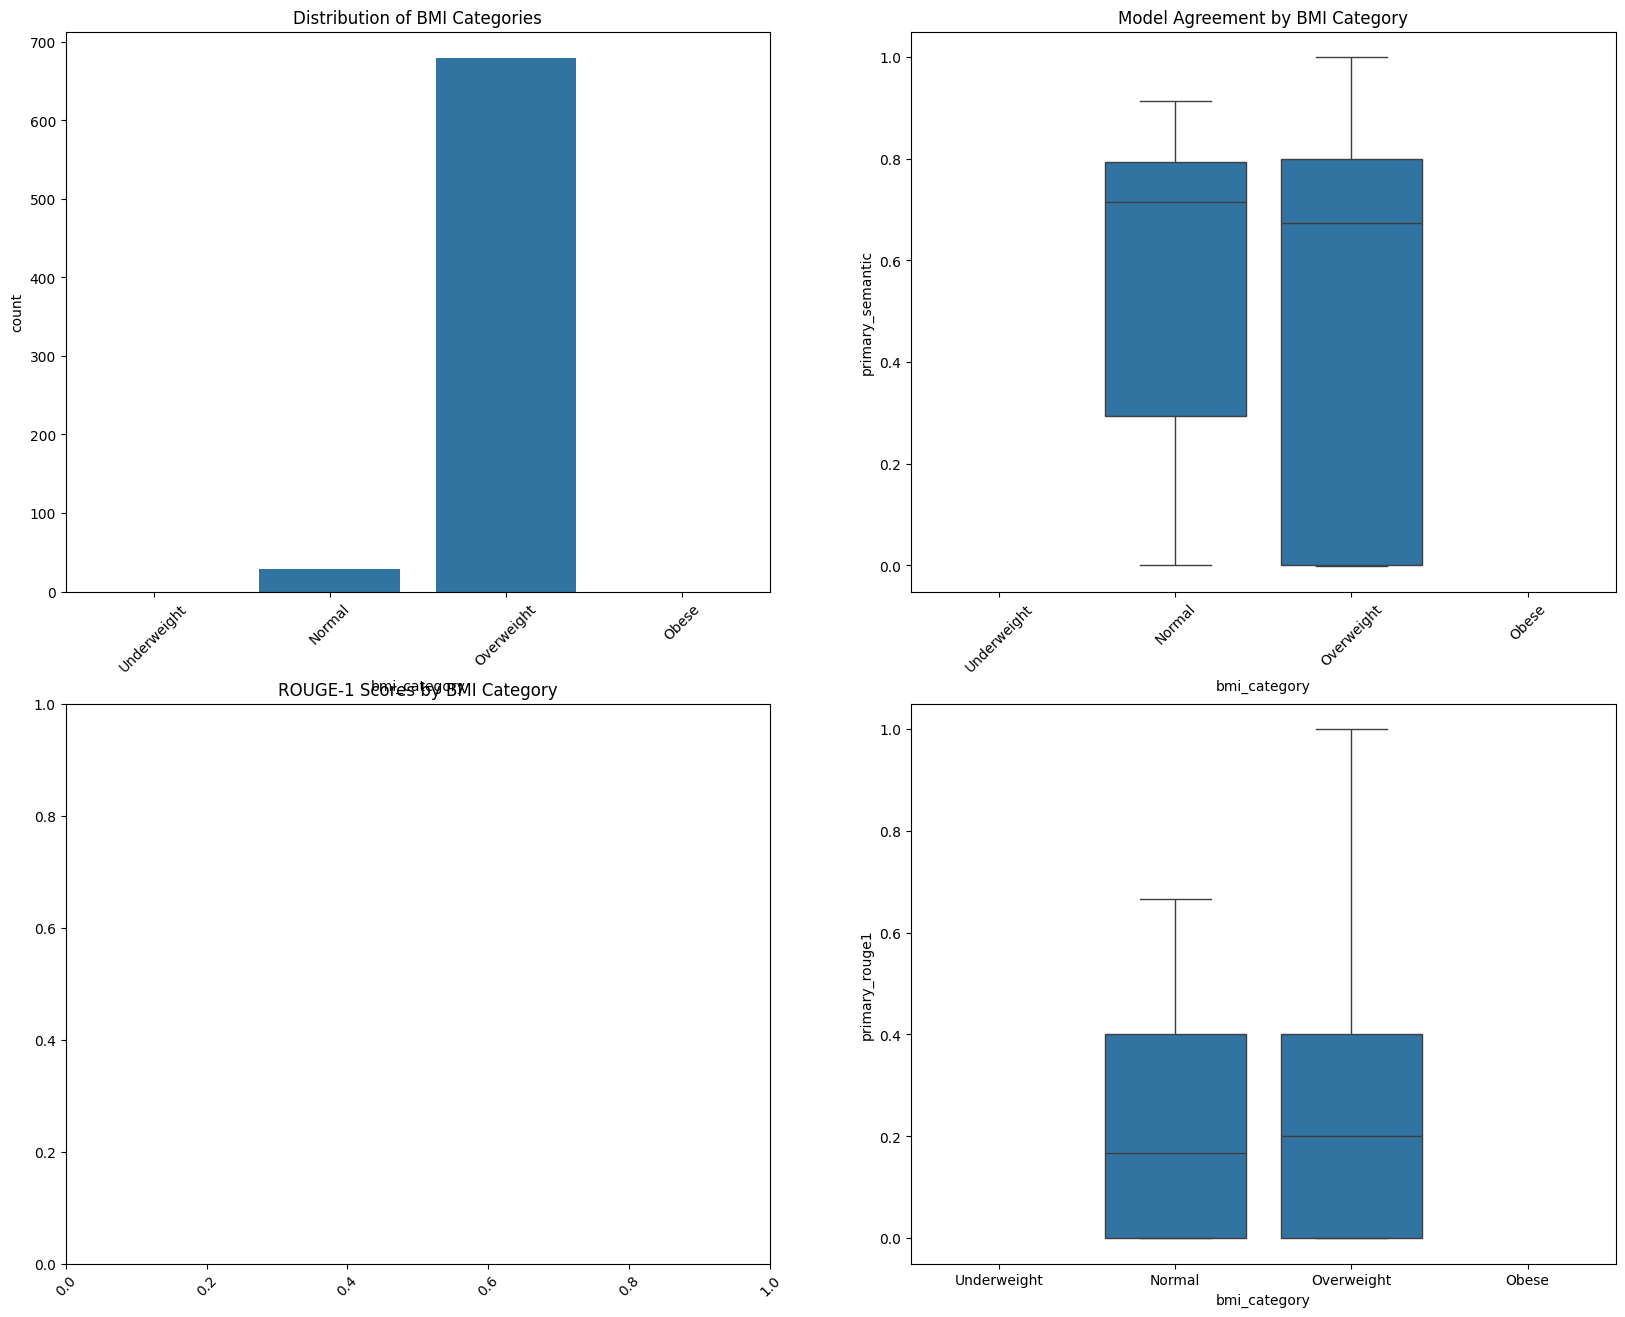

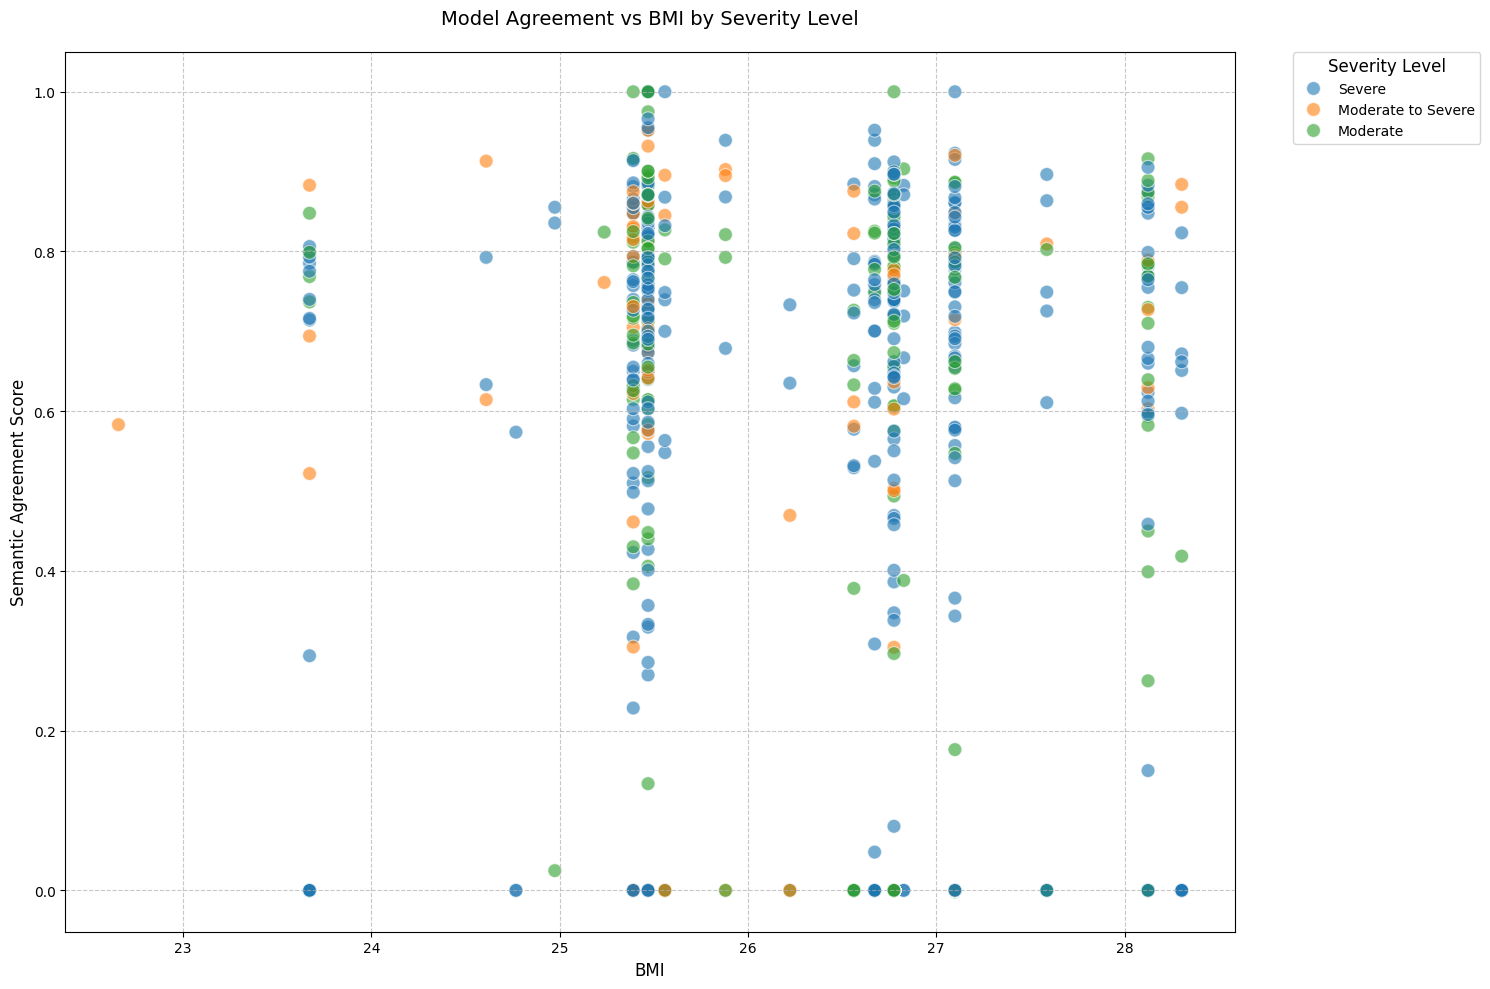


Summary Statistics by Severity Level:
                   primary_semantic                  bmi       
                               mean    std count    mean    std
severity_simple                                                
Moderate                      0.516  0.358   200  26.347  1.017
Moderate to Severe            0.532  0.349    92  26.109  1.120
Severe                        0.531  0.343   416  26.330  1.030

Detailed BMI Analysis:
{
  "condition_complexity": {
    "Underweight": NaN,
    "Normal": 3.206896551724138,
    "Overweight": 3.2665684830633284,
    "Obese": NaN
  },
  "symptom_patterns": {
    "Underweight": {},
    "Normal": {
      "the": 57,
      "right": 53,
      "pain": 29,
      "radiating": 28,
      "in": 24
    },
    "Overweight": {
      "the": 1251,
      "right": 956,
      "radiating": 662,
      "pain": 661,
      "in": 636
    },
    "Obese": {}
  },
  "treatment_patterns": {
    "Underweight": {},
    "Normal": {
      "-": 69,
      "and": 38,
 

/tmp/ipykernel_230270/3181101192.py:304: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detailed_analysis['condition_complexity'] = self.df.groupby('bmi_category')['num_conditions'].mean().to_dict()
/tmp/ipykernel_230270/3181101192.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detailed_analysis['symptom_patterns'] = self.df.groupby('bmi_category').apply(get_common_symptoms).to_dict()
/tmp/ipykernel_230270/3181101192.py:313: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded fro

In [170]:
bmi_analysis = analyzer.analyze_bmi_bias()
print("\nBMI Analysis Summary:")
print(json.dumps(bmi_analysis, indent=2))

# Visualize BMI patterns
analyzer.visualize_bmi_analysis()

# Get detailed BMI analysis
detailed_bmi = analyzer.detailed_bmi_analysis()
print("\nDetailed BMI Analysis:")
print(json.dumps(detailed_bmi, indent=2))

/tmp/ipykernel_230270/3181101192.py:399: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  agreement_pivot = pd.pivot_table(
/tmp/ipykernel_230270/3181101192.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Semantic Score': self.df.groupby('bmi_category')['primary_semantic'].mean(),
/tmp/ipykernel_230270/3181101192.py:420: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'ROUGE Score': self.df.groupby('bmi_category')['primary_rouge1'].mean(),
/tmp/i

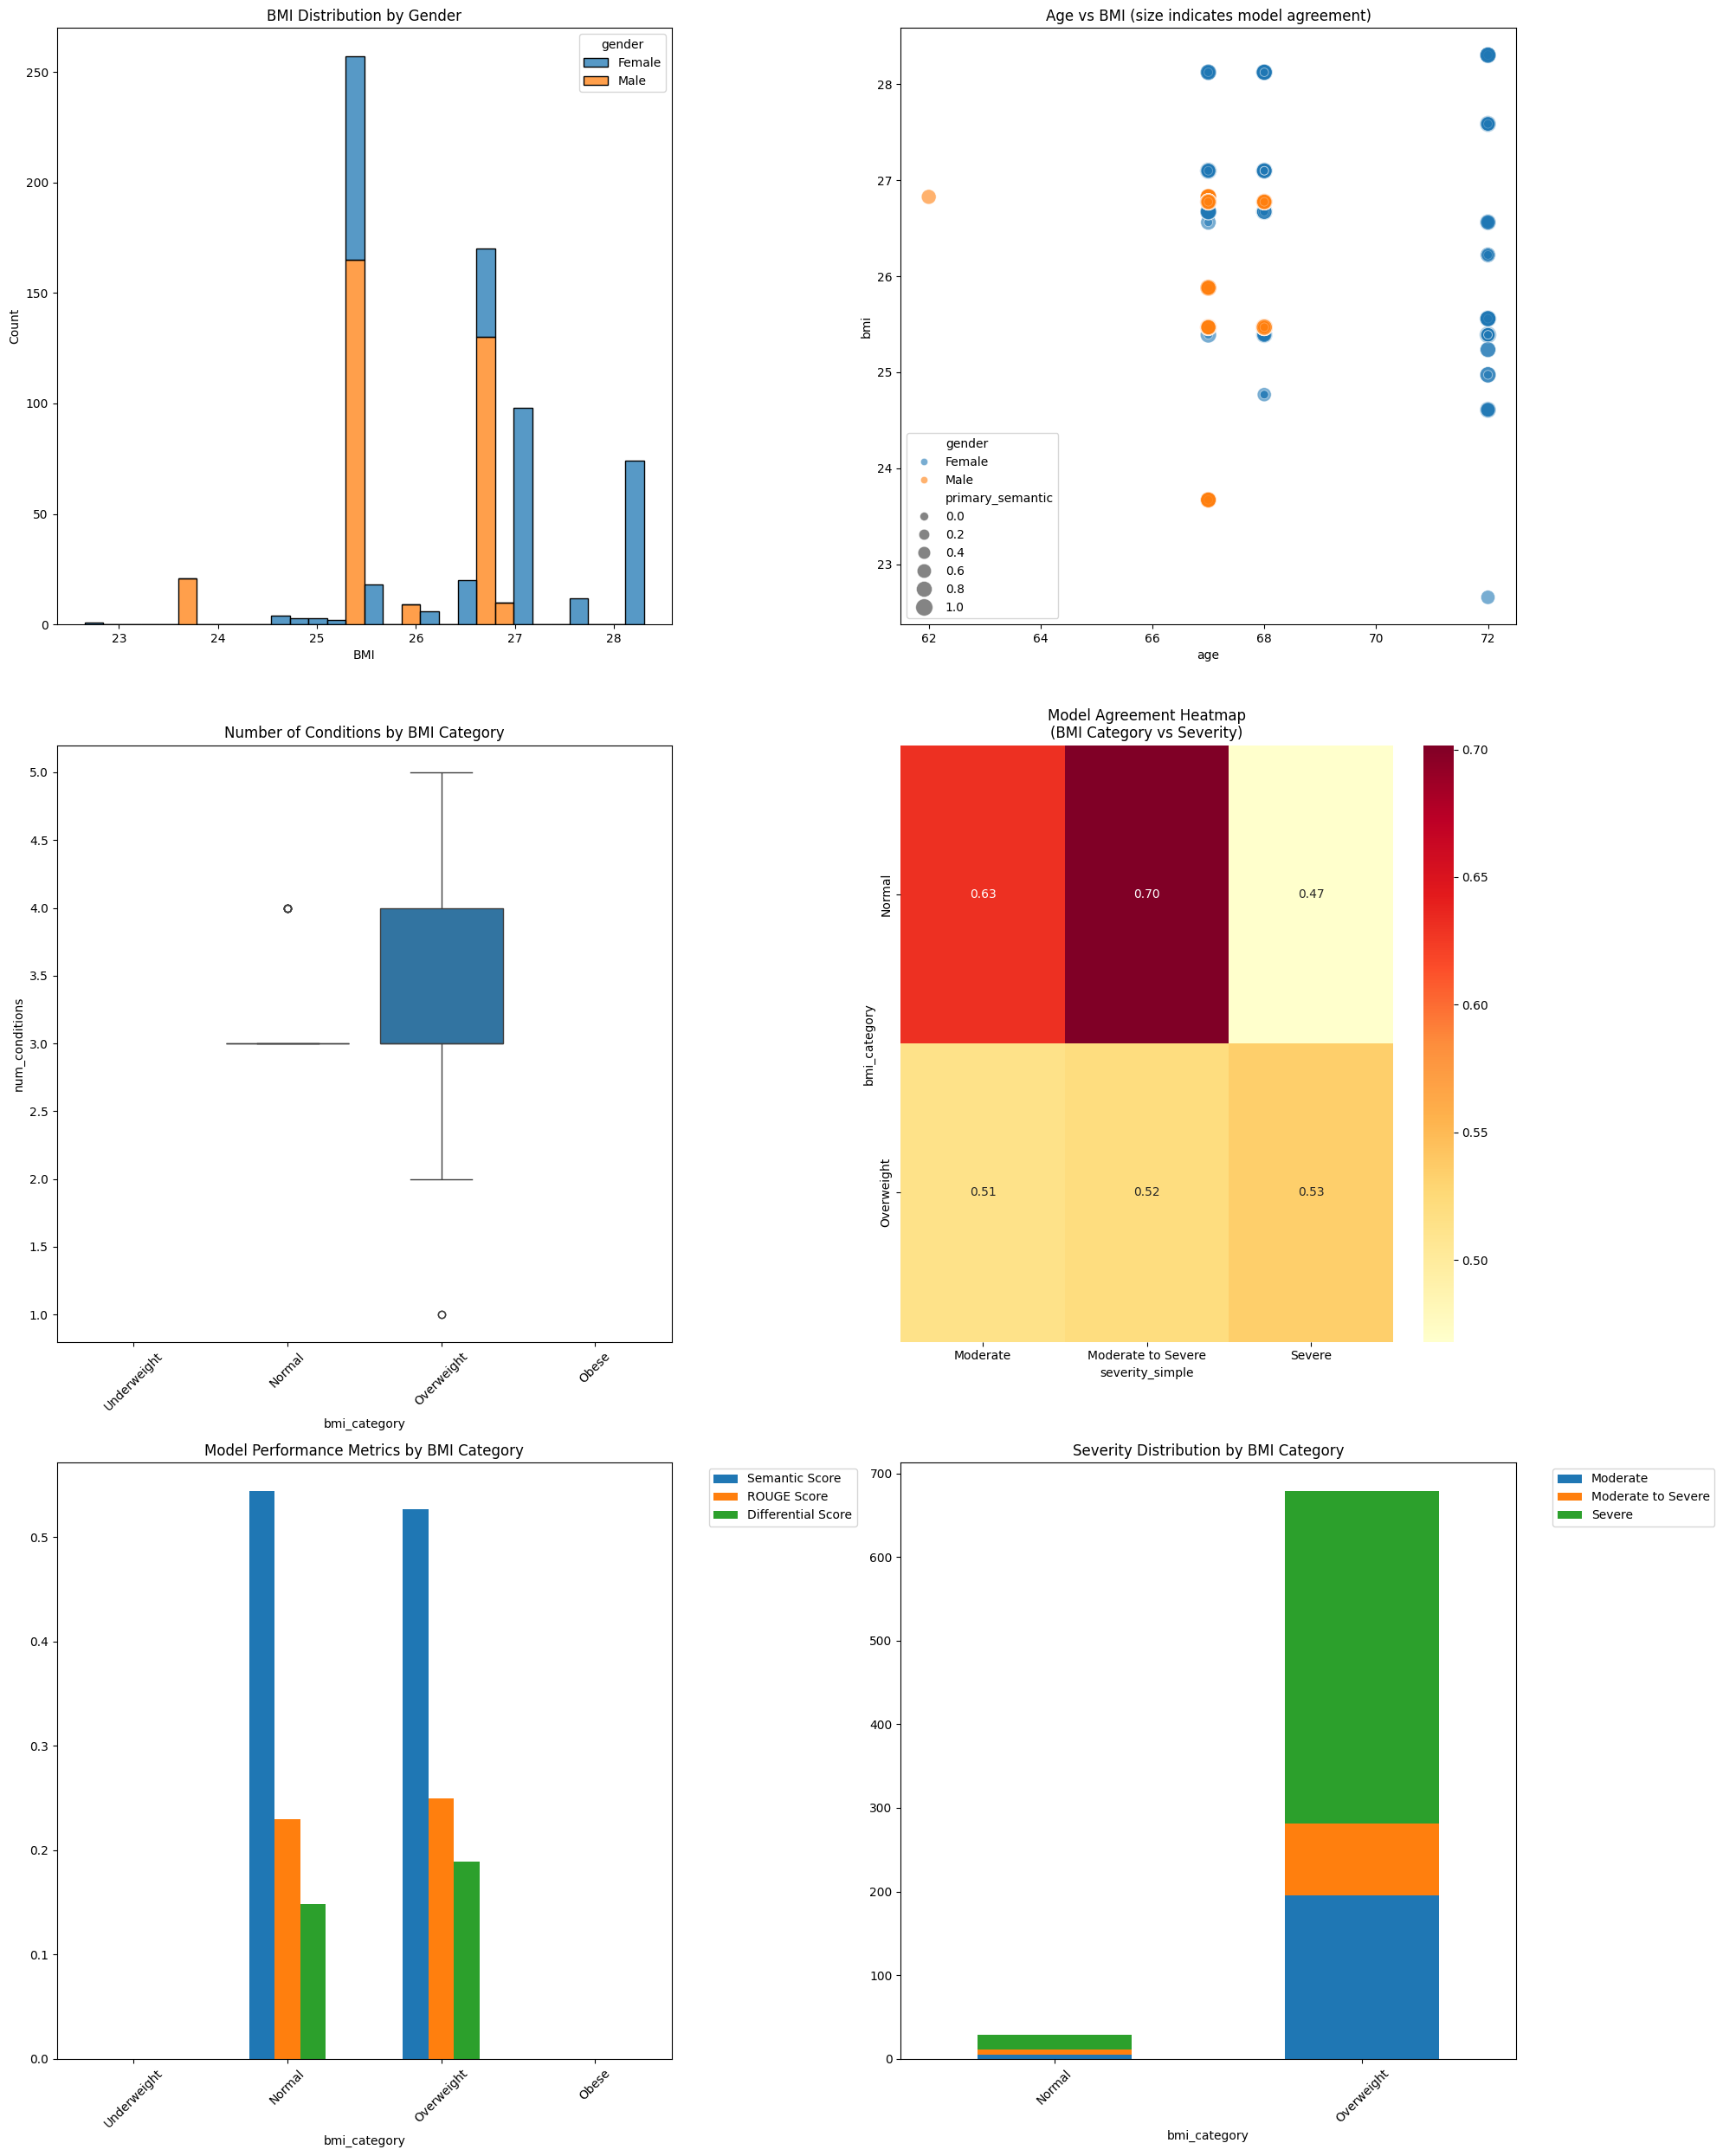


Summary Statistics:
             primary_semantic             num_conditions    age
                         mean   std count           mean   mean
bmi_category                                                   
Underweight               NaN   NaN     0            NaN    NaN
Normal                   0.54  0.33    29           3.21  67.97
Overweight               0.53  0.35   679           3.27  68.48
Obese                     NaN   NaN     0            NaN    NaN


/tmp/ipykernel_230270/3181101192.py:441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = self.df.groupby('bmi_category').agg({


In [171]:
analyzer.visualize_comprehensive_analysis()

In [118]:
def analyze_sensitivity(df):
    """Analyze model sensitivity to input variations"""
    
    # Symptom Description Length Sensitivity
    df['symptom_length'] = df['symptoms'].str.len()
    df['symptom_length_group'] = pd.qcut(df['symptom_length'], q=4, 
                                        labels=['Short', 'Medium', 'Long', 'Very Long'])
    
    symptom_length_sensitivity = df.groupby('symptom_length_group').agg({
        'primary_semantic': ['mean', 'std'],
        'primary_rouge1': ['mean', 'std']
    }).round(3)
    
    # Duration Sensitivity
    duration_sensitivity = df.groupby('symptom_duration_days').agg({
        'primary_semantic': ['mean', 'std'],
        'primary_rouge1': ['mean', 'std']
    }).round(3)
    
    # Medical History Complexity Sensitivity
    history_sensitivity = df.groupby('num_conditions').agg({
        'primary_semantic': ['mean', 'std'],
        'primary_rouge1': ['mean', 'std']
    }).round(3)
    
    return {
        'symptom_length_sensitivity': symptom_length_sensitivity,
        'duration_sensitivity': duration_sensitivity,
        'history_sensitivity': history_sensitivity
    }

In [119]:
def analyze_robustness(df):
    """Analyze model robustness across different conditions"""
    
    # Consistency across similar cases
    def find_similar_cases(row):
        similar = df[
            (df['age_group'] == row['age_group']) &
            (df['gender'] == row['gender']) &
            (df['severity'] == row['severity'])
        ]
        return similar['primary_semantic'].std()
    
    df['consistency_score'] = df.apply(find_similar_cases, axis=1)
    
    # Edge case handling
    edge_cases = df[
        (df['age'] >= 80) | 
        (df['num_conditions'] >= 5) |
        (df['symptom_duration_days'] >= 180)
    ]
    
    edge_case_performance = edge_cases.agg({
        'primary_semantic': ['mean', 'std'],
        'primary_rouge1': ['mean', 'std']
    }).round(3)
    
    return {
        'consistency_stats': df['consistency_score'].describe(),
        'edge_case_performance': edge_case_performance
    }

## meteor score, semantic overlap precision, recall, f1, token overlap jaccard similarity